# Aufgabe 1
In einem Betrieb werden CD-Rohlinge auf vier Maschinen mit folgenden Produktions- und Ausschussanteilen gefertigt:   
- Maschine Produktionsanteil Ausschussanteil   
- 1 &emsp;&emsp;&emsp;&emsp;&emsp; 40% &emsp;&emsp;&emsp;&emsp;&emsp; 1%   
- 2 &emsp;&emsp;&emsp;&emsp;&emsp; 30% &emsp;&emsp;&emsp;&emsp;&emsp; 2%   
- 3 &emsp;&emsp;&emsp;&emsp;&emsp; 20% &emsp;&emsp;&emsp;&emsp;&emsp; 4%   
- 4 &emsp;&emsp;&emsp;&emsp;&emsp; 10% &emsp;&emsp;&emsp;&emsp;&emsp; 5%  
 
a) Berechne die Wahrscheinlichkeit dafür, dass ein im Betrieb gefertigter Rohling defekt ist.   
b) Mit welcher Wahrscheinlichkeit wurde ein defekter Rohling von Maschine 1 produziert?

In [208]:
Production = {"M1": 0.4, "M2": 0.3, "M3": 0.2, "M4": 0.1}
conditionProbs = [0.01, 0.02, 0.04, 0.05] # Probabiltities for the event A to be true

In [209]:
from igraph import Graph, EdgeSeq
import itertools
import plotly.graph_objects as go
import numpy as np
n = 1

conditionProbsCalculated = list(itertools.chain.from_iterable((i, 1-i) for i in conditionProbs))
nr_vertices = int((1-len(Production)**(n+1))/(1-len(Production))) # nr of verticies calculated by geometrical series, assumes symmetrical tree
v_label = list(Production.keys()) + (["A", "!A"] * len(Production)) # create the labels

v_label.insert(0, "- root") # add the root node
G = Graph.Tree(nr_vertices, len(Production)) # n stands for children number

# add the second layer, update nr of verticies
G.add_vertices(len(Production)*2)
nr_vertices = nr_vertices + 2*len(Production)
G.add_edges([(int(np.ceil(i/2)), len(Production)+i) for i in range(1, len(Production)*2 +1)])

lay = G.layout_reingold_tilford(mode='in', root=[0])

position = {k: lay[k] for k in range(nr_vertices)}
Y = [lay[k][1] for k in range(nr_vertices)]
M = max(Y)

es = EdgeSeq(G) # sequence of edges
E = [e.tuple for e in G.es] # list of edges

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [2*M-position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe+=[position[edge[0]][0],position[edge[1]][0], None]
    Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None]

labels = v_label

# set the paths accordingly
allPaths = []
for i in range(n+1):
    allPaths.extend(list(itertools.product(Production.keys(), repeat=i)))

# second layer
allPaths.extend(list(itertools.product(Production.keys(), ["A", "!A"])))
G.vs["path"] = allPaths

# calculate the probabilities 
lastProb = [] # saving the last probability per node for labeling
allProbs = [1]
for i in range(1, nr_vertices): # calculate the number of nodes using geometric series, skip root node
    val = 1
    Production_copy = Production.copy()
    for j, item in enumerate(G.vs[i]["path"]): # the idea is to trace the path back from the root, using the path vector
        if item in Production_copy: 
            val = Production_copy[item]
        else: # second layer: i > len(Production)+1; item is A or !0
            val = conditionProbsCalculated[i-1-len(Production)]
        if j+1 == len(G.vs[i]["path"]):
            lastProb.append(val)
    if (i-1-len(Production) < 0):
        allProbs.append(val)
    else:
        probVector = [a*b for a,b in zip(np.repeat(list(Production.values()), 2), conditionProbsCalculated)]
        prob = probVector[(i-1-len(Production))] / sum(probVector[(i-1)%2::2])
        allProbs.append(prob)


G.vs["lastprob"] = lastProb
G.vs["prob"] = allProbs

def make_annotations(pos, text, font_size=10, font_color='rgb(250,250,250)'):
    L=len(pos)
    annotations = []
    for k in range(L):
        annotations.append(
            dict(
                text=labels[k], # set the first letter of description to node
                x=pos[k][0], y=2*M-position[k][1],
                xref='x1', yref='y1',
                font=dict(color=font_color, size=font_size),
                showarrow=False)
        )
    
    # annotations for path probability
    for i in range(2, len(Xe), 3): # start off with the third value in the array and bypassing None types
        annotations.append(dict(
            text=f"{G.vs[int((i-2)/3)]['lastprob']}", 
            x=(Xe[i-1]+Xe[i-2])/2, y=(Ye[i-1]+Ye[i-2])/2,
            xref='x1', yref='y1',
            font=dict(color="black", size=font_size),
            showarrow=False)
        )

    # annotation for probability of last elements
    for i in range(nr_vertices - len(Production)*2, nr_vertices):
        annotations.append(dict(
            text=f"{G.vs[i]['prob']:.4f}", 
            x=Xn[i], y=Yn[i]-0.15,
            xref='x1', yref='y1',
            font=dict(color="black", size=font_size),
            showarrow=False)
        )
    
    return annotations

fig = go.Figure()
fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=2),
                   opacity=0.8
                   ))
fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  marker=dict(symbol='circle-dot',
                                size=18,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=list(zip(allPaths, np.array(allProbs).astype(str))),
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(annotations=make_annotations(position, v_label),
              xaxis=axis,
              yaxis=axis,
              showlegend=False
              )
fig.show()

# Aufgabe 2
In einer Urne liegen insgesamt $u+g$ mit Zahlen beschriftete Zettel. Auf $g$ dieser Zettel steht eine gerade
Zahl, auf $u$ Zetteln eine ungerade Zahl. Ohne Zurücklegen werden zwei Zettel gezogen, die Summe
beider Zahlen ist gerade. Wie groß ist die Wahrscheinlichkeit, dass auf dem ersten Zettel eine gerade
Zahl stand?

Überlegung: 
- Ereignis B: Der erste gezogene Zettel ist gerade
- Ereignis A: Die Summe beider Zettel ist gerade

In [210]:
from sympy.abc import u, g

Production = {"B_1": g/(u+g), "B_2": u/(u+g)}
conditionProbs = [(g-1)/(u+g-1), (u-1)/(u+g-1)]

In [211]:
from igraph import Graph, EdgeSeq
import itertools
import plotly.graph_objects as go
import numpy as np
from sympy import simplify
n = 1

conditionProbsCalculated = list(itertools.chain.from_iterable((i, 1-i) for i in conditionProbs))
nr_vertices = int((1-len(Production)**(n+1))/(1-len(Production))) # nr of verticies calculated by geometrical series, assumes symmetrical tree
v_label = list(Production.keys()) + (["A", "!A"] * len(Production)) # create the labels

v_label.insert(0, "- root") # add the root node
G = Graph.Tree(nr_vertices, len(Production)) # n stands for children number

# add the second layer, update nr of verticies
G.add_vertices(len(Production)*2)
nr_vertices = nr_vertices + 2*len(Production)
G.add_edges([(int(np.ceil(i/2)), len(Production)+i) for i in range(1, len(Production)*2 +1)])

lay = G.layout_reingold_tilford(mode='in', root=[0])

position = {k: lay[k] for k in range(nr_vertices)}
Y = [lay[k][1] for k in range(nr_vertices)]
M = max(Y)

es = EdgeSeq(G) # sequence of edges
E = [e.tuple for e in G.es] # list of edges

L = len(position)
Xn = [position[k][0] for k in range(L)]
Yn = [2*M-position[k][1] for k in range(L)]
Xe = []
Ye = []
for edge in E:
    Xe+=[position[edge[0]][0],position[edge[1]][0], None]
    Ye+=[2*M-position[edge[0]][1],2*M-position[edge[1]][1], None]

labels = v_label

# set the paths accordingly
allPaths = []
for i in range(n+1):
    allPaths.extend(list(itertools.product(Production.keys(), repeat=i)))

# second layer
allPaths.extend(list(itertools.product(Production.keys(), ["A", "!A"])))
G.vs["path"] = allPaths

# calculate the probabilities 
lastProb = [] # saving the last probability per node for labeling
allProbs = [1]
for i in range(1, nr_vertices): # calculate the number of nodes using geometric series, skip root node
    val = 1
    Production_copy = Production.copy()
    for j, item in enumerate(G.vs[i]["path"]): # the idea is to trace the path back from the root, using the path vector
        if item in Production_copy: 
            val = Production_copy[item]
        else: # second layer: i > len(Production)+1; item is A or !0
            val = conditionProbsCalculated[i-1-len(Production)]
        if j+1 == len(G.vs[i]["path"]):
            lastProb.append(val)
    if (i-1-len(Production) < 0):
        allProbs.append(val)
    else:
        probVector = [a*b for a,b in zip(np.repeat(list(Production.values()), 2), conditionProbsCalculated)]
        prob = probVector[(i-1-len(Production))] / sum(probVector[(i-1)%2::2])
        allProbs.append(simplify(prob))


G.vs["lastprob"] = lastProb
G.vs["prob"] = allProbs

def make_annotations(pos, text, font_size=10, font_color='rgb(250,250,250)'):
    L=len(pos)
    annotations = []
    for k in range(L):
        annotations.append(
            dict(
                text=labels[k], # set the first letter of description to node
                x=pos[k][0], y=2*M-position[k][1],
                xref='x1', yref='y1',
                font=dict(color=font_color, size=font_size),
                showarrow=False)
        )
    
    # annotations for path probability
    for i in range(2, len(Xe), 3): # start off with the third value in the array and bypassing None types
        annotations.append(dict(
            text=f"{G.vs[int((i-2)/3)]['lastprob']}", 
            x=(Xe[i-1]+Xe[i-2])/2, y=(Ye[i-1]+Ye[i-2])/2,
            xref='x1', yref='y1',
            font=dict(color="black", size=font_size),
            showarrow=False)
        )

    # annotation for probability of last elements
    for i in range(nr_vertices - len(Production)*2, nr_vertices):
        annotations.append(dict(
            text=f"{G.vs[i]['prob']}", 
            x=Xn[i], y=Yn[i]-0.15,
            xref='x1', yref='y1',
            font=dict(color="black", size=font_size),
            showarrow=False)
        )
    
    return annotations

fig = go.Figure()
fig.add_trace(go.Scatter(x=Xe,
                   y=Ye,
                   mode='lines',
                   line=dict(color='rgb(210,210,210)', width=2),
                   opacity=0.8
                   ))
fig.add_trace(go.Scatter(x=Xn,
                  y=Yn,
                  mode='markers',
                  marker=dict(symbol='circle-dot',
                                size=18,
                                color='#6175c1',    #'#DB4551',
                                line=dict(color='rgb(50,50,50)', width=1)
                                ),
                  text=list(zip(allPaths, np.array(allProbs).astype(str))),
                  hoverinfo='text',
                  opacity=0.8
                  ))

axis = dict(showline=False, # hide axis line, grid, ticklabels and  title
            zeroline=False,
            showgrid=False,
            showticklabels=False,
            )

fig.update_layout(annotations=make_annotations(position, v_label),
              xaxis=axis,
              yaxis=axis,
              showlegend=False
              )
fig.show()

# Aufgabe 3
Aus einer Urne mit sieben roten und drei grünen Kugeln werden solange Kugeln ohne Zurücklegen gezogen
bis eine rote gezogen wird. Der Zufallsgröße $X$ werde die Anzahl der Züge zugeordnet.
- Bestimme die Verteilung von $X$ (Verteilungstabelle)

$\Omega = \{R, GR, GGR, GGGR\}$   

x  &emsp;| &emsp;1&emsp; | &emsp;2&emsp; | &emsp;3&emsp; |&emsp; 4    
\-------------------------------   
pi &emsp;| $\frac{7}{10}$ &emsp; | $\frac{7}{30}$ &emsp; | $\frac{7}{120}$&emsp;  | $\frac{1}{120}$

Zeichne das zur Wahrscheinlichkeitsfunktion gehörige Stabdiagramm sowie die zur Verteilungsfunktion
gehörige Treppenfunktion.

In [212]:
x = [1,2,3,4]
pi = [7/10, 7/30, 7/120, 1/120]

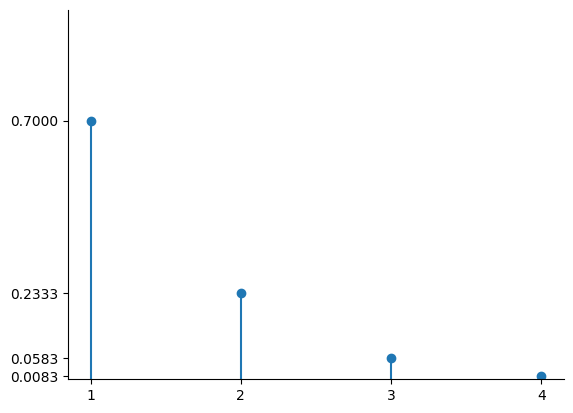

In [220]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.plot(x, pi, 'o')
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.vlines(x, 0, pi)
ax.set_ylim(0,1)
ax.set_xticks(x)
ax.set_yticks(pi)
plt.show()

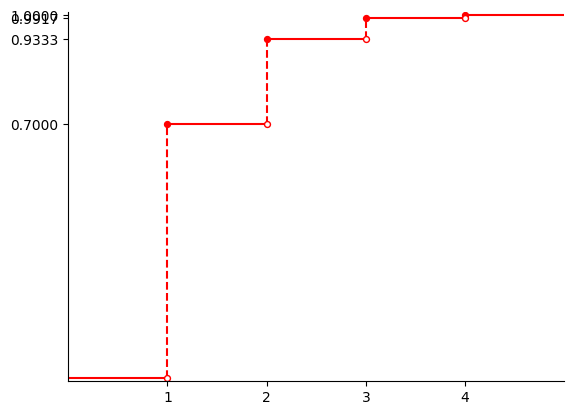

In [222]:
pi_cumulated = [sum(pi[0:i]) for i in range(1,len(pi)+1)]

data = np.arange(0, len(pi_cumulated)+2)
y = np.array(pi_cumulated)
yn = np.insert(y, 0, 0)

fig, ax = plt.subplots()
ax.set_facecolor('white')

ax.hlines(y=yn, xmin=data[:-1], xmax=data[1:],
          color='red', zorder=1)

ax.vlines(x=data[1:-1], ymin=yn[:-1], ymax=yn[1:], color='red',
          linestyle='dashed', zorder=1)

ax.grid(False)
ax.set_xlim(data[0], data[-1])
ax.set_ylim([-0.01, 1.01])
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_xticks(x)
ax.set_yticks(pi_cumulated)

ax.scatter(data[1:-1], y, color='red', s=18, zorder=2)
ax.scatter(data[1:-1], yn[:-1], color='white', s=18, zorder=2,
           edgecolor='red')
plt.show()

- Bestimme Erwartungswert, Varianz und Standardabweichung von X

In [224]:
from sympy.stats import FiniteRV, E, variance, std

pmf = dict(zip(x, pi))
X = FiniteRV('X', pmf)

print(f'expectation value µ = {E(X)}')
print(f'variance σ² = {variance(X)}')
print(f'standard deviation σ = {std(X)}')




expectation value µ = 1.37500000000000
variance σ² = 0.401041666666667
standard deviation σ = 0.633278506398778
